# Second order hypothesis testing

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os
import torch
import imp

import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from scvi.dataset import CortexDataset, RetinaDataset, PbmcDataset
from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.metrics.differential_expression import de_stats
from scvi.metrics.imputation import imputation
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

from scvi_extensions.inference.supervised_variational_inference import SupervisedVariationalInference

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import scvi_extensions.hypothesis_testing.utils as utils
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.variance as vr
import scvi_extensions.dataset.label_data_loader as ldl

## Loading data

Here we load the CORTEX dataset described in

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

Please see our data loading Jupyter notebook for more examples of data loading -- scVI has many "built-in" datasets, as well as support for loading arbitrary .csv, .loom, and .h5ad (AnnData) files.

In [6]:
gene_dataset = CortexDataset()

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA. 


In [7]:
n_epochs=200
lr=1e-3
use_batches=False
use_cuda=False

**Train the model and output model likelihood every 5 epochs**

In [8]:
model = VAEC(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches)
infer = SupervisedVariationalInference(
    model, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=False,
    frequency=1)
#infer.train(n_epochs=n_epochs, lr=lr)

In [9]:
#torch.save(vae, '/Users/mincheolkim/Documents/cortext_vaec.model')

In [10]:
vae = torch.load('/Users/mincheolkim/Documents/cortext_vae.model')

/anaconda3/envs/scvi/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'scvi.models.modules.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


** Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

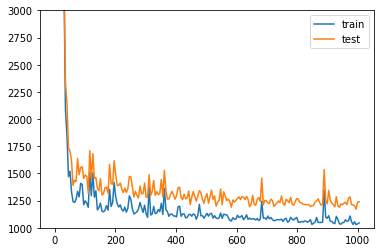

In [42]:
ll_train = np.array(infer.history["ll_train"])
ll_test = np.array(infer.history["ll_test"])*10
x = np.linspace(0,len(ll_train)*5,(len(ll_train)))
plt.plot(x, ll_train)
plt.plot(x, ll_test)
plt.legend(['train', 'test'])
plt.ylim([1000, 3000])
plt.show()

In [11]:
for tensors in infer.data_loaders['sequential']:
    sample_batch, local_l_mean, local_l_var, batch_index, labels = tensors
    break

## Variance calculation

In [11]:
imp.reload(utils)
imp.reload(vr)

<module 'scvi_extensions.hypothesis_testing.variance' from '/Users/mincheolkim/Github/scVI-extensions/scvi_extensions/hypothesis_testing/variance.py'>

In [13]:
desired_labels, counts = np.unique(gene_dataset.labels, return_counts=True)
M_sampling=100

In [14]:
data_loader = ldl.LabelDataLoaders(
    gene_dataset=gene_dataset, 
    desired_labels=desired_labels,
    num_samples=10000)

In [15]:
imp.reload(utils)
px_scale, all_labels = utils.expression_stats(
    vae, 
    data_loader['all'], 
    M_sampling=M_sampling)

In [17]:
variances = (px_scale.reshape(-1, M_sampling, px_scale.shape[-1])*1e6).var(axis=1)
labels = all_labels.reshape(-1, M_sampling).mean(axis=1)

In [18]:
wl_rates, wl_bfs = utils.get_bayes_factors(0, 0, variances, labels, null=False)
il_rates, il_bfs = utils.get_bayes_factors(0, 1, variances, labels)

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


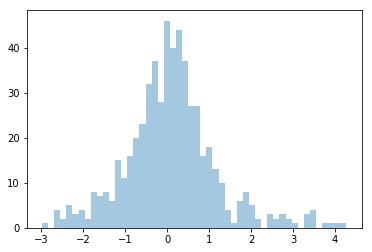

In [19]:
sns.distplot(il_bfs, kde=False, bins=50);

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Variance null Bayes Factors')

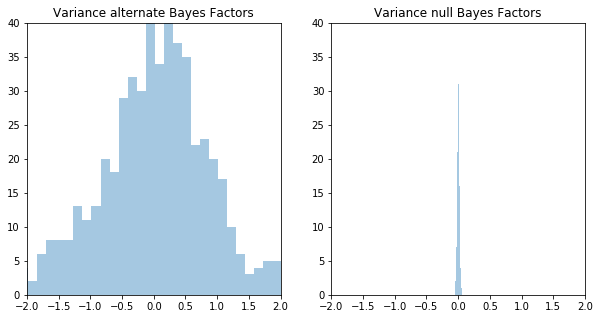

In [142]:
plt.figure(figsize=(10, 5));
plt.subplot(1, 2, 1);
sns.distplot(il_bfs, kde=False, bins=50);
plt.xlim([-2, 2]);plt.ylim([0, 40]);
plt.title('Variance alternate Bayes Factors')
plt.subplot(1, 2, 2);
sns.distplot(wl_bfs, kde=False, bins=50);
plt.xlim([-2, 2]);plt.ylim([0, 40]);
plt.title('Variance null Bayes Factors')